In [135]:
# Dependencies
import requests
import json
from private_info.config import api_key, fromdate, todate
from private_info.opendata_config import token311, password, username
import pandas as pd
from datetime import datetime
import sys
# sys.path.append('/path/to/your/dev/environment/lib/python3.10/site-packages')
from sodapy import Socrata
import matplotlib.pyplot as plt



##### In the following script we'll try to analize the following
---
##### NYC311 can provide you access to non-emergency City services and information about City government programs. NYC311 can help with a broad range of services, including things like homeless person assistance, pothole repair, or help understanding a property tax bill. over 500 services

- which are the top 10 most popular report ploblems 311 receives (top 3 apartment mainrenance complaint, ilegal parking and noise from neighbor)
- what's the time gap they take to solve problems 
- what location report more issues in nyc 
- What burough has the highest level of 311 calls
- Were the 311 calls resolved (which burough has the highest resolution rate)
- Which category of service is the best/worst

### Extracting NYC API Developers data from api-portal.nyc.gov

In [86]:
# URL for GET requests to retrieve vehicle data
url_calendar= f'https://api.nyc.gov/public/api/GetCalendar?fromdate={fromdate}&todate={todate}'
headers = {'Ocp-Apim-Subscription-Key': api_key}

In [87]:
# Print the response object to the console
response = requests.get(url_calendar, headers=headers)
print(response.status_code)

200


In [88]:
# Retrieving data and converting it into JSON
response_json =response.json()

In [89]:
# Pretty Print the output of the JSON
print(json.dumps(response_json, indent=4, sort_keys=True))

{
    "days": [
        {
            "items": [
                {
                    "details": "Alternate side parking and meters are suspended for New Year's Day.",
                    "exceptionName": "New Year's Day 2024",
                    "status": "SUSPENDED",
                    "type": "Alternate Side Parking"
                },
                {
                    "details": "Trash, recycling, and compost collections are suspended for New Year's Day.",
                    "exceptionName": "New Year's Day 2024",
                    "status": "SUSPENDED",
                    "type": "Collections"
                },
                {
                    "details": "Public schools are closed for Winter Recess. Students return Tuesday.",
                    "exceptionName": "Winter Recess Last Day 2024",
                    "status": "CLOSED",
                    "type": "Schools"
                }
            ],
            "today_id": "20240101"
        },
        {
       

In [90]:
#create a dataframe from json response 
api_df = response_json
api_df

{'days': [{'today_id': '20240101',
   'items': [{'exceptionName': "New Year's Day 2024",
     'details': "Alternate side parking and meters are suspended for New Year's Day.",
     'status': 'SUSPENDED',
     'type': 'Alternate Side Parking'},
    {'exceptionName': "New Year's Day 2024",
     'details': "Trash, recycling, and compost collections are suspended for New Year's Day.",
     'status': 'SUSPENDED',
     'type': 'Collections'},
    {'exceptionName': 'Winter Recess Last Day 2024',
     'details': 'Public schools are closed for Winter Recess. Students return Tuesday.',
     'status': 'CLOSED',
     'type': 'Schools'}]},
  {'today_id': '20240102',
   'items': [{'details': 'Alternate side parking and meters are in effect.',
     'status': 'IN EFFECT',
     'type': 'Alternate Side Parking'},
    {'exceptionName': "New Year's Day Delayed 1/2 - 1/3/24",
     'details': 'Trash, recycling, and compost collections are delayed due to the backlog from the recent holiday.',
     'status': 

In [91]:
#create a empty list to store data
rows = []
# Loop through the data and extract information
for day in api_df['days']:
    today_id = day['today_id']
    for type in day['items']:
        row = {'today_id': today_id}
        row.update(type)
        rows.append(row)
trash_cleaned_df = pd.DataFrame(rows)
#display dataframe 
trash_cleaned_df

,today_id,exceptionName,details,status,type
0,20240101,New Year's Day 2024,Alternate side parking and meters are suspende...,SUSPENDED,Alternate Side Parking
1,20240101,New Year's Day 2024,"Trash, recycling, and compost collections are ...",SUSPENDED,Collections
2,20240101,Winter Recess Last Day 2024,Public schools are closed for Winter Recess. S...,CLOSED,Schools
3,20240102,NaN,Alternate side parking and meters are in effect.,IN EFFECT,Alternate Side Parking
4,20240102,New Year's Day Delayed 1/2 - 1/3/24,"Trash, recycling, and compost collections are ...",DELAYED,Collections
...,...,...,...,...,...
130,20240213,Lincoln's Birthday and Snow Delayed 2/13 - 2/1...,"Trash, recycling, and compost collections are ...",DELAYED,Collections
131,20240213,Snow 2/13/2024,All public school students are scheduled for r...,REMOTE ONLY,Schools
132,20240214,Ash Wednesday 2024,Alternate side parking is suspended for Ash We...,SUSPENDED,Alternate Side Parking
133,20240214,Lincoln's Birthday and Snow Delayed 2/13 - 2/1...,"Trash, recycling, and compost collections are ...",DELAYED,Collections


In [92]:
collections_list = []

# Iterating over each 'day' in the 'days' column of api_df
for day in api_df['days']:
    # Iterating over each 'item' in the 'items' list of the current 'day'
    for item in day['items']:
        # Appending a dictionary to collections_list for each 'item'
        collections_list.append({
            'today_id': day['today_id'],  # Storing 'today_id' from the current 'day'
            'status': item['status'],     # Storing 'status' from the current 'item'
            'type': item['type']          # Storing 'type' from the current 'item'
        })

# Creating a DataFrame using collections_list
types_df = pd.DataFrame(collections_list)

# Filtering rows in types_df where 'type' column equals 'Collections'
specific_type = 'Collections'
trash_filtered_df = types_df[types_df['type'] == specific_type]

# Displaying the first few rows of the filtered DataFrame
trash_filtered_df.head()


,today_id,status,type
1,20240101,SUSPENDED,Collections
4,20240102,DELAYED,Collections
7,20240103,DELAYED,Collections
10,20240104,ON SCHEDULE,Collections
13,20240105,ON SCHEDULE,Collections


### Extracting the the first trimester of 2024 from 311 service request dataset open data 

In [136]:
# Define date range
start_date = datetime(2024, 1, 1).isoformat()  # January 1, 2023
end_date = datetime(2024, 4, 1).isoformat()  # January 1, 2024


# Example authenticated client (needed for non-public datasets):
client = Socrata(
    "data.cityofnewyork.us",
    token311,
    username= username,
    password= password,
    timeout=1000
)

# First 794354 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
# Query dataset with date filter 
#in this case we se a limit of limit=794354 because that's the number of rows we need to get the first trimester, we cannot set it to default because it only retrive 1000 max.
results = client.get("erm2-nwe9", where=f"created_date between '{start_date}' and '{end_date}'", limit=794354)
print(len(results))
# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)


794354


In [94]:
#Displaying the 311 service request dataframe 
results_df

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,...,location,vehicle_type,facility_type,due_date,taxi_pick_up_location,bridge_highway_name,bridge_highway_segment,bridge_highway_direction,road_ramp,taxi_company_borough
0,60746805,2024-04-01T00:00:00.000,2024-04-01T00:00:01.000,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Restaurant/Bar/Deli/Bakery,11211,76 AINSLIE STREET,...,"{'latitude': '40.71256007953489', 'longitude':...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,60740007,2024-03-31T23:59:36.000,2024-04-01T05:20:38.000,DOT,Department of Transportation,Street Sign - Damaged,"No Parking, Standing, Stopping",Street,11205,920 KENT AVENUE,...,"{'latitude': '40.693075024696356', 'longitude'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,60734332,2024-03-31T23:59:09.000,2024-04-01T09:12:45.000,HPD,Department of Housing Preservation and Develop...,HEAT/HOT WATER,ENTIRE BUILDING,RESIDENTIAL BUILDING,10454,313 EAST 140 STREET,...,"{'latitude': '40.81154285376075', 'longitude':...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,60738841,2024-03-31T23:58:47.000,2024-04-02T22:34:59.000,HPD,Department of Housing Preservation and Develop...,HEAT/HOT WATER,APARTMENT ONLY,RESIDENTIAL BUILDING,10128,1670 YORK AVENUE,...,"{'latitude': '40.777070197706855', 'longitude'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,60739109,2024-03-31T23:58:39.000,2024-04-02T15:08:50.000,DOT,Department of Transportation,Street Condition,Defective Hardware,Street,10009,324 EAST 8 STREET,...,"{'latitude': '40.72501024136251', 'longitude':...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794349,59887043,2024-01-01T00:00:20.000,2024-01-01T00:41:01.000,NYPD,New York City Police Department,Illegal Fireworks,N/A,Street/Sidewalk,11228,7223 FORT HAMILTON PARKWAY,...,"{'latitude': '40.62709413549678', 'longitude':...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
794350,59896272,2024-01-01T00:00:00.000,2024-01-02T00:00:01.000,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Restaurant/Bar/Deli/Bakery,11211,145 GRAND STREET EXTENSION,...,"{'latitude': '40.710675306389646', 'longitude'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
794351,59899838,2024-01-01T00:00:00.000,2024-01-02T09:42:25.000,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Restaurant/Bar/Deli/Bakery,10022,1069 1 AVENUE,...,"{'latitude': '40.759191822016476', 'longitude'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
794352,59894610,2024-01-01T00:00:00.000,2024-01-02T09:46:32.000,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Restaurant/Bar/Deli/Bakery,10304,7 NAVY PIER COURT,...,"{'latitude': '40.628827651071944', 'longitude'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [95]:
#Getting a brief summary of the results_df dataframe 
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 794354 entries, 0 to 794353
Data columns (total 41 columns):
 #   Column                          Non-Null Count   Dtype 
---  ------                          --------------   ----- 
 0   unique_key                      794354 non-null  object
 1   created_date                    794354 non-null  object
 2   closed_date                     774257 non-null  object
 3   agency                          794354 non-null  object
 4   agency_name                     794354 non-null  object
 5   complaint_type                  794354 non-null  object
 6   descriptor                      788994 non-null  object
 7   location_type                   695950 non-null  object
 8   incident_zip                    785089 non-null  object
 9   incident_address                762451 non-null  object
 10  street_name                     762428 non-null  object
 11  cross_street_1                  502948 non-null  object
 12  cross_street_2                

In [96]:
# Get the results_df columns
results_df.columns

Index(['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
       'complaint_type', 'descriptor', 'location_type', 'incident_zip',
       'incident_address', 'street_name', 'cross_street_1', 'cross_street_2',
       'intersection_street_1', 'intersection_street_2', 'address_type',
       'city', 'landmark', 'status', 'resolution_description',
       'resolution_action_updated_date', 'community_board', 'bbl', 'borough',
       'x_coordinate_state_plane', 'y_coordinate_state_plane',
       'open_data_channel_type', 'park_facility_name', 'park_borough',
       'latitude', 'longitude', 'location', 'vehicle_type', 'facility_type',
       'due_date', 'taxi_pick_up_location', 'bridge_highway_name',
       'bridge_highway_segment', 'bridge_highway_direction', 'road_ramp',
       'taxi_company_borough'],
      dtype='object')

In [97]:
#Assigning  location and location_subtype values to the location and location_subtype columns 
try:
    results_df[['location_', 'location_subtype']] = results_df['location_type'].str.split("/", n=1, expand=True)

except  ValueError:

    results_df['location_subtype'] = None 
results_df.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,...,facility_type,due_date,taxi_pick_up_location,bridge_highway_name,bridge_highway_segment,bridge_highway_direction,road_ramp,taxi_company_borough,location_,location_subtype
0,60746805,2024-04-01T00:00:00.000,2024-04-01T00:00:01.000,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Restaurant/Bar/Deli/Bakery,11211,76 AINSLIE STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Restaurant,Bar/Deli/Bakery
1,60740007,2024-03-31T23:59:36.000,2024-04-01T05:20:38.000,DOT,Department of Transportation,Street Sign - Damaged,"No Parking, Standing, Stopping",Street,11205,920 KENT AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Street,None
2,60734332,2024-03-31T23:59:09.000,2024-04-01T09:12:45.000,HPD,Department of Housing Preservation and Develop...,HEAT/HOT WATER,ENTIRE BUILDING,RESIDENTIAL BUILDING,10454,313 EAST 140 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RESIDENTIAL BUILDING,None
3,60738841,2024-03-31T23:58:47.000,2024-04-02T22:34:59.000,HPD,Department of Housing Preservation and Develop...,HEAT/HOT WATER,APARTMENT ONLY,RESIDENTIAL BUILDING,10128,1670 YORK AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RESIDENTIAL BUILDING,None
4,60739109,2024-03-31T23:58:39.000,2024-04-02T15:08:50.000,DOT,Department of Transportation,Street Condition,Defective Hardware,Street,10009,324 EAST 8 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Street,None


In [98]:
# Get the results_df columns
results_df.columns

Index(['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
       'complaint_type', 'descriptor', 'location_type', 'incident_zip',
       'incident_address', 'street_name', 'cross_street_1', 'cross_street_2',
       'intersection_street_1', 'intersection_street_2', 'address_type',
       'city', 'landmark', 'status', 'resolution_description',
       'resolution_action_updated_date', 'community_board', 'bbl', 'borough',
       'x_coordinate_state_plane', 'y_coordinate_state_plane',
       'open_data_channel_type', 'park_facility_name', 'park_borough',
       'latitude', 'longitude', 'location', 'vehicle_type', 'facility_type',
       'due_date', 'taxi_pick_up_location', 'bridge_highway_name',
       'bridge_highway_segment', 'bridge_highway_direction', 'road_ramp',
       'taxi_company_borough', 'location_', 'location_subtype'],
      dtype='object')

In [99]:
#Doucble check how it looks like and the delete the location_type column
results_df[['location_type', 'location_','location_subtype']]
results_df_ = results_df.drop(['location_type'], axis=1)
results_df_.columns

Index(['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
       'complaint_type', 'descriptor', 'incident_zip', 'incident_address',
       'street_name', 'cross_street_1', 'cross_street_2',
       'intersection_street_1', 'intersection_street_2', 'address_type',
       'city', 'landmark', 'status', 'resolution_description',
       'resolution_action_updated_date', 'community_board', 'bbl', 'borough',
       'x_coordinate_state_plane', 'y_coordinate_state_plane',
       'open_data_channel_type', 'park_facility_name', 'park_borough',
       'latitude', 'longitude', 'location', 'vehicle_type', 'facility_type',
       'due_date', 'taxi_pick_up_location', 'bridge_highway_name',
       'bridge_highway_segment', 'bridge_highway_direction', 'road_ramp',
       'taxi_company_borough', 'location_', 'location_subtype'],
      dtype='object')

### Updating 311 service dataframe datatype
---

In [100]:
# Create a copy of the results_df_ dataframe 
copy_311service_request = results_df_.copy()
copy_311service_request.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,facility_type,due_date,taxi_pick_up_location,bridge_highway_name,bridge_highway_segment,bridge_highway_direction,road_ramp,taxi_company_borough,location_,location_subtype
0,60746805,2024-04-01T00:00:00.000,2024-04-01T00:00:01.000,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,11211,76 AINSLIE STREET,AINSLIE STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Restaurant,Bar/Deli/Bakery
1,60740007,2024-03-31T23:59:36.000,2024-04-01T05:20:38.000,DOT,Department of Transportation,Street Sign - Damaged,"No Parking, Standing, Stopping",11205,920 KENT AVENUE,KENT AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Street,None
2,60734332,2024-03-31T23:59:09.000,2024-04-01T09:12:45.000,HPD,Department of Housing Preservation and Develop...,HEAT/HOT WATER,ENTIRE BUILDING,10454,313 EAST 140 STREET,EAST 140 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RESIDENTIAL BUILDING,None
3,60738841,2024-03-31T23:58:47.000,2024-04-02T22:34:59.000,HPD,Department of Housing Preservation and Develop...,HEAT/HOT WATER,APARTMENT ONLY,10128,1670 YORK AVENUE,YORK AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RESIDENTIAL BUILDING,None
4,60739109,2024-03-31T23:58:39.000,2024-04-02T15:08:50.000,DOT,Department of Transportation,Street Condition,Defective Hardware,10009,324 EAST 8 STREET,EAST 8 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Street,None


In [101]:
#Renaming the descriptor column
copy_311service_request = copy_311service_request.rename(columns={'descriptor': 'complaint_descriptor','location_': 'location_type'})

In [102]:
#reordering dataframe with location and location_subtype after descriptor 
# and we're also ignoring the 'agency_name' column since the metadata says that column is currenlty showing incorrect values.
nyc311_service_line = copy_311service_request[['unique_key', 'created_date', 'closed_date', 'agency',
       'complaint_type', 'complaint_descriptor','location_type','location_subtype', 'incident_zip', 'incident_address',
       'street_name', 'cross_street_1', 'cross_street_2',
       'intersection_street_1', 'intersection_street_2', 'address_type',
       'city', 'landmark', 'status', 'resolution_description',
       'resolution_action_updated_date', 'community_board', 'bbl', 'borough',
       'x_coordinate_state_plane', 'y_coordinate_state_plane',
       'open_data_channel_type', 'park_facility_name', 'park_borough',
       'latitude', 'longitude', 'vehicle_type', 'facility_type',
       'due_date', 'taxi_pick_up_location', 'bridge_highway_name',
       'bridge_highway_segment', 'bridge_highway_direction', 'road_ramp',
       'taxi_company_borough']]

In [103]:
# # Convert the created_date, closed_date, due_date, and resolution_action_updated_date  columns to datetime format

nyc311_service_line['created_date'] = pd.to_datetime(nyc311_service_line['created_date'])
nyc311_service_line['closed_date'] = pd.to_datetime(nyc311_service_line['closed_date'])
nyc311_service_line[ 'due_date'] = pd.to_datetime(nyc311_service_line['due_date'])
nyc311_service_line['resolution_action_updated_date'] = pd.to_datetime(nyc311_service_line['resolution_action_updated_date'])

# #using loc function to avoid SettingWithCopyWarning

# Convert date columns to datetime format
date_columns = ['created_date', 'closed_date', 'due_date', 'resolution_action_updated_date']
for col in date_columns:
    nyc311_service_line.loc[:,col] = pd.to_datetime(nyc311_service_line[col])


C:\Users\Alyssa Jones\AppData\Local\Temp\ipykernel_20012\3632430456.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyc311_service_line['created_date'] = pd.to_datetime(nyc311_service_line['created_date'])
C:\Users\Alyssa Jones\AppData\Local\Temp\ipykernel_20012\3632430456.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyc311_service_line['closed_date'] = pd.to_datetime(nyc311_service_line['closed_date'])
C:\Users\Alyssa Jones\AppData\Local\Temp\ipykernel_20012\3632430456.py:5: SettingWithCopyWarni

In [104]:
# Convert latitude and longitude columns to float format
float_columns = ['latitude', 'longitude']
for float_column in float_columns:
    nyc311_service_line[float_column] = nyc311_service_line[float_column].astype(float)
# # Convert y_coordinate_state_plane and x_coordinate_state_plane columns to integer format
int_columns = ['y_coordinate_state_plane', 'x_coordinate_state_plane']
for int_column in int_columns:
    nyc311_service_line[int_column] = nyc311_service_line[int_column].fillna(0).astype(int)
#convert incident_zip and unique_key to integer columns
integers_columns = [ 'incident_zip', 'unique_key'] # here we have the columns without Nan values
for integer_columns in integers_columns:
    nyc311_service_line[integer_columns] = nyc311_service_line[integer_columns].fillna(0).astype(int)

C:\Users\Alyssa Jones\AppData\Local\Temp\ipykernel_20012\1352411129.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyc311_service_line[float_column] = nyc311_service_line[float_column].astype(float)
C:\Users\Alyssa Jones\AppData\Local\Temp\ipykernel_20012\1352411129.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyc311_service_line[float_column] = nyc311_service_line[float_column].astype(float)
C:\Users\Alyssa Jones\AppData\Local\Temp\ipykernel_20012\1352411129.py:8: SettingWithCopyWarning: 
A val

In [105]:
# Checking the datatypes
nyc311_service_line.dtypes

unique_key                                 int32
created_date                      datetime64[ns]
closed_date                       datetime64[ns]
agency                                    object
complaint_type                            object
complaint_descriptor                      object
location_type                             object
location_subtype                          object
incident_zip                               int32
incident_address                          object
street_name                               object
cross_street_1                            object
cross_street_2                            object
intersection_street_1                     object
intersection_street_2                     object
address_type                              object
city                                      object
landmark                                  object
status                                    object
resolution_description                    object
resolution_action_up

In [106]:
nyc311_service_line.columns

Index(['unique_key', 'created_date', 'closed_date', 'agency', 'complaint_type',
       'complaint_descriptor', 'location_type', 'location_subtype',
       'incident_zip', 'incident_address', 'street_name', 'cross_street_1',
       'cross_street_2', 'intersection_street_1', 'intersection_street_2',
       'address_type', 'city', 'landmark', 'status', 'resolution_description',
       'resolution_action_updated_date', 'community_board', 'bbl', 'borough',
       'x_coordinate_state_plane', 'y_coordinate_state_plane',
       'open_data_channel_type', 'park_facility_name', 'park_borough',
       'latitude', 'longitude', 'vehicle_type', 'facility_type', 'due_date',
       'taxi_pick_up_location', 'bridge_highway_name',
       'bridge_highway_segment', 'bridge_highway_direction', 'road_ramp',
       'taxi_company_borough'],
      dtype='object')

In [107]:
nyc311_service_line.head()

,unique_key,created_date,closed_date,agency,complaint_type,complaint_descriptor,location_type,location_subtype,incident_zip,incident_address,...,longitude,vehicle_type,facility_type,due_date,taxi_pick_up_location,bridge_highway_name,bridge_highway_segment,bridge_highway_direction,road_ramp,taxi_company_borough
0,60746805,2024-04-01 00:00:00,2024-04-01 00:00:01,DOHMH,Food Poisoning,1 or 2,Restaurant,Bar/Deli/Bakery,11211,76 AINSLIE STREET,...,-73.951899,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1,60740007,2024-03-31 23:59:36,2024-04-01 05:20:38,DOT,Street Sign - Damaged,"No Parking, Standing, Stopping",Street,None,11205,920 KENT AVENUE,...,-73.959093,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2,60734332,2024-03-31 23:59:09,2024-04-01 09:12:45,HPD,HEAT/HOT WATER,ENTIRE BUILDING,RESIDENTIAL BUILDING,None,10454,313 EAST 140 STREET,...,-73.924611,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
3,60738841,2024-03-31 23:58:47,2024-04-02 22:34:59,HPD,HEAT/HOT WATER,APARTMENT ONLY,RESIDENTIAL BUILDING,None,10128,1670 YORK AVENUE,...,-73.946274,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
4,60739109,2024-03-31 23:58:39,2024-04-02 15:08:50,DOT,Street Condition,Defective Hardware,Street,None,10009,324 EAST 8 STREET,...,-73.979179,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN


In [108]:
# Create the nyc311 location dataframe 
nyc311_location =nyc311_service_line[['unique_key', 'borough', 'latitude', 'longitude', 'x_coordinate_state_plane', 'y_coordinate_state_plane','due_date']]
nyc311_location.tail()

,unique_key,borough,latitude,longitude,x_coordinate_state_plane,y_coordinate_state_plane,due_date
794349,59887043,BROOKLYN,40.627094,-74.014497,980226,167744,NaT
794350,59896272,BROOKLYN,40.710675,-73.954050,996989,198198,NaT
794351,59899838,MANHATTAN,40.759192,-73.962290,994697,215873,NaT
794352,59894610,STATEN ISLAND,40.628828,-74.074387,963602,168384,NaT
794353,59898042,BRONX,40.845340,-73.865594,1021437,247286,NaT


In [109]:
# Export the  nyc311_service_line DataFrame as a CSV file. 
nyc311_service_line.to_csv("Resources/nyc311_service_line.csv", index=False)

In [110]:
# Export the  nyc311_location DataFrame as a CSV file. 
nyc311_location.to_csv("Resources/nyc311_location.csv", index=False)

In [111]:
boroughs_df = pd.DataFrame(nyc311_location['borough']).value_counts().reset_index()
boroughs_df

,borough,count
0,BROOKLYN,247148
1,QUEENS,190308
2,MANHATTAN,165901
3,BRONX,162956
4,STATEN ISLAND,27423
5,Unspecified,618


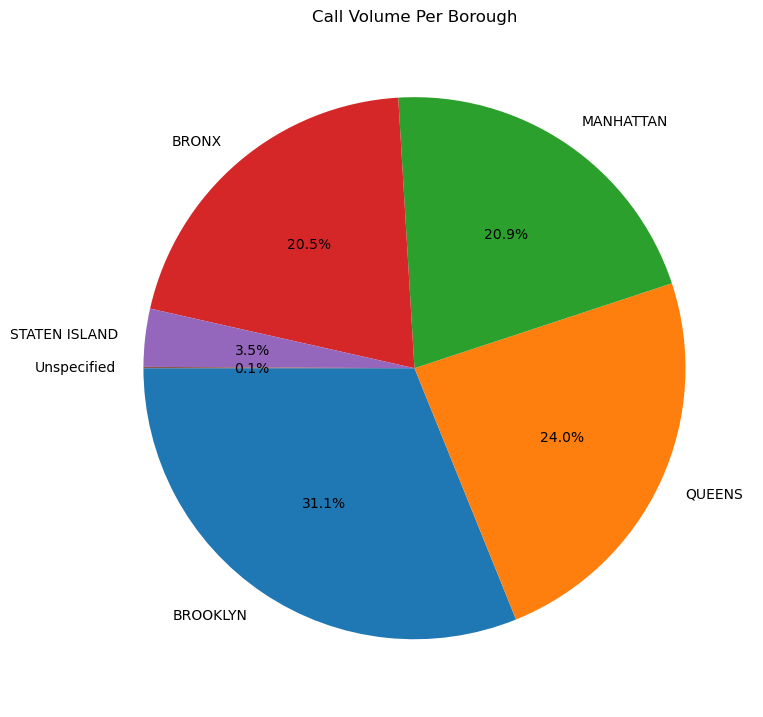

In [124]:
# PIE GRAPH
borough_call_count= nyc311_location['borough'].value_counts()
plt.figure(figsize=(8.8,8.8)) # Setting the Figure Size of the Pie Graph
borough_call_count.plot.pie(autopct='%1.1f%%', startangle=180) # Setting Up and Coding the Pie Chart
plt.title('Call Volume Per Borough') # Title of Pie Chart
plt.ylabel('') # Gets Rid of Text on Y-axis
plt.show() # Displays Pie Chart

In [113]:
complaint_df = nyc311_service_line['complaint_type'].value_counts()
complaint_df.head()

complaint_type
Illegal Parking         123083
HEAT/HOT WATER          106450
Noise - Residential      68498
Blocked Driveway         43067
UNSANITARY CONDITION     28192
Name: count, dtype: int64

In [114]:
complaint_df = nyc311_service_line['complaint_type'].value_counts()
complaint_df.tail()

complaint_type
Building Marshals office           1
Construction Safety Enforcement    1
DSNY Internal                      1
Executive Inspections              1
Radioactive Material               1
Name: count, dtype: int64

In [115]:
complaints_per_borough = nyc311_service_line[['complaint_type', 'borough']]
complaints_per_borough

,complaint_type,borough
0,Food Poisoning,BROOKLYN
1,Street Sign - Damaged,BROOKLYN
2,HEAT/HOT WATER,BRONX
3,HEAT/HOT WATER,MANHATTAN
4,Street Condition,MANHATTAN
...,...,...
794349,Illegal Fireworks,BROOKLYN
794350,Food Poisoning,BROOKLYN
794351,Food Poisoning,MANHATTAN
794352,Food Poisoning,STATEN ISLAND


In [137]:
brooklyn_complaints = nyc311_service_line[nyc311_service_line['borough'] == 'BROOKLYN']
brooklyn_complaints_counts = brooklyn_complaints.groupby('complaint_type').size()
brooklyn_complaints_df = brooklyn_complaints_counts.reset_index(name='count')
brooklyn_complaints_sorted = brooklyn_complaints_df.sort_values(by='count', ascending=False)
brooklyn_complaints_sorted.head()

,complaint_type,count
74,Illegal Parking,47599
63,HEAT/HOT WATER,26906
99,Noise - Residential,20500
14,Blocked Driveway,16436
145,UNSANITARY CONDITION,8458


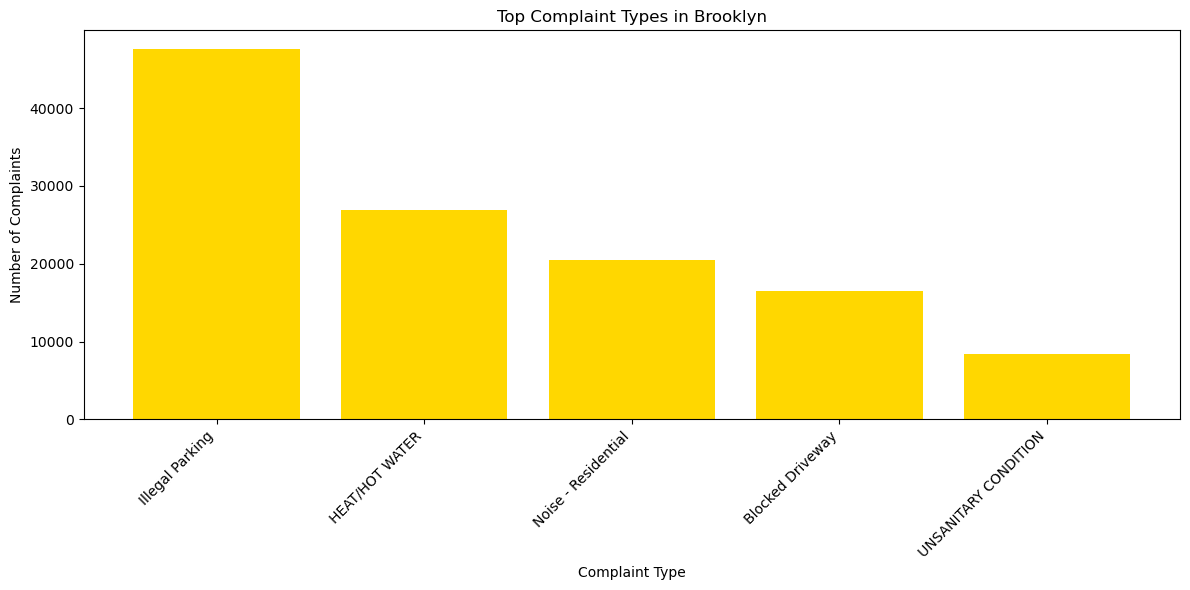

In [154]:
# Create the bar graph
plt.figure(figsize=(12, 6))
plt.bar(brooklyn_complaints_sorted['complaint_type'][:5], brooklyn_complaints_sorted['count'][:5], color='gold')
plt.xlabel('Complaint Type')
plt.ylabel('Number of Complaints')
plt.title('Top Complaint Types in Brooklyn')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [141]:
queens_complaints = nyc311_service_line[nyc311_service_line['borough'] == 'QUEENS']
queens_complaints_counts = queens_complaints.groupby('complaint_type').size()
queens_complaints_df = queens_complaints_counts.reset_index(name='count')
queens_complaints_sorted = queens_complaints_df.sort_values(by='count', ascending=False)
queens_complaints_sorted.head()


,complaint_type,count
73,Illegal Parking,36358
13,Blocked Driveway,17947
61,HEAT/HOT WATER,15756
97,Noise - Residential,13720
2,Abandoned Vehicle,6980


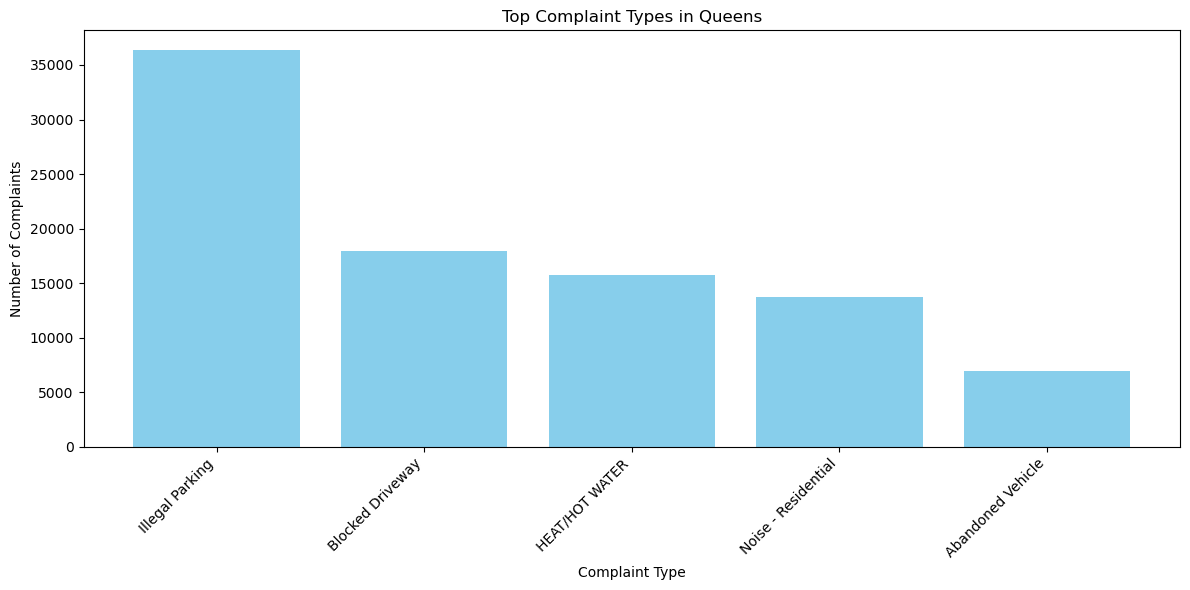

In [142]:
plt.figure(figsize=(12, 6))
plt.bar(queens_complaints_sorted['complaint_type'][:5], queens_complaints_sorted['count'][:5], color='skyblue')
plt.xlabel('Complaint Type')
plt.ylabel('Number of Complaints')
plt.title('Top Complaint Types in Queens')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [143]:
manhattan_complaints = nyc311_service_line[nyc311_service_line['borough'] == 'MANHATTAN']
manhattan_complaints_counts = manhattan_complaints.groupby('complaint_type').size()
manhattan_complaints_df = manhattan_complaints_counts.reset_index(name='count')
manhattan_complaints_sorted = manhattan_complaints_df.sort_values(by='count', ascending=False)
manhattan_complaints_sorted.head()

,complaint_type,count
65,HEAT/HOT WATER,23341
76,Illegal Parking,17072
102,Noise - Residential,14808
103,Noise - Street/Sidewalk,6538
98,Noise - Commercial,5370


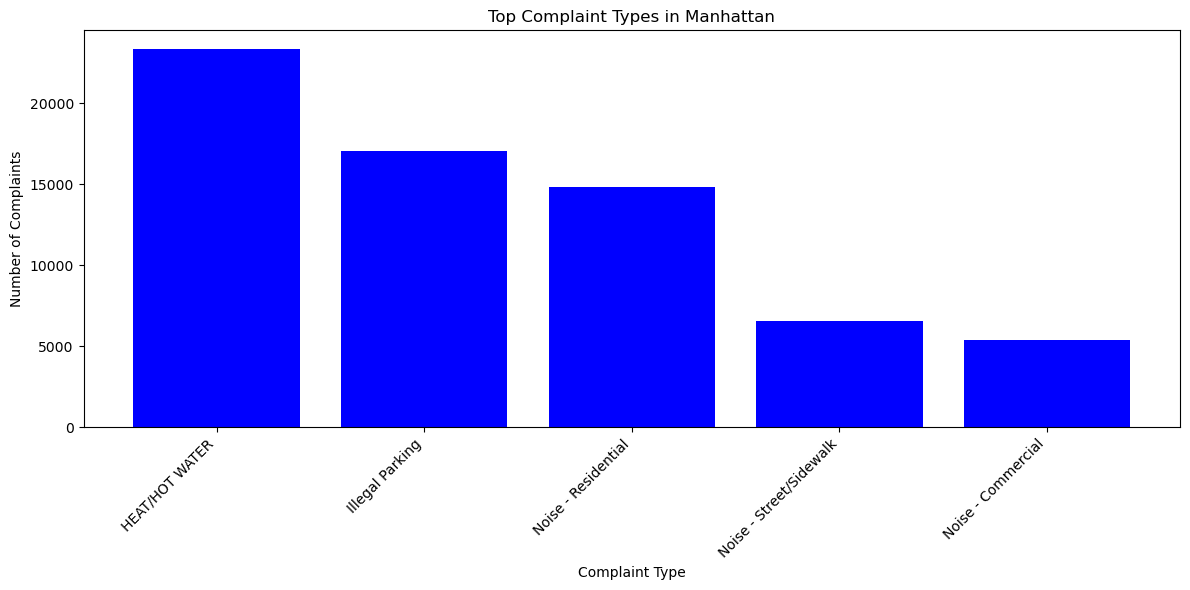

In [153]:
plt.figure(figsize=(12, 6))
plt.bar(manhattan_complaints_sorted['complaint_type'][:5], manhattan_complaints_sorted['count'][:5], color='blue')
plt.xlabel('Complaint Type')
plt.ylabel('Number of Complaints')
plt.title('Top Complaint Types in Manhattan')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [145]:
bronx_complaints = nyc311_service_line[nyc311_service_line['borough'] == 'BRONX']
bronx_complaints_counts = bronx_complaints.groupby('complaint_type').size()
bronx_complaints_df = bronx_complaints_counts.reset_index(name='count')
bronx_complaints_sorted = bronx_complaints_df.sort_values(by='count', ascending=False)
bronx_complaints_sorted.head()

,complaint_type,count
61,HEAT/HOT WATER,39312
72,Illegal Parking,18466
95,Noise - Residential,17944
141,UNSANITARY CONDITION,9521
13,Blocked Driveway,6367


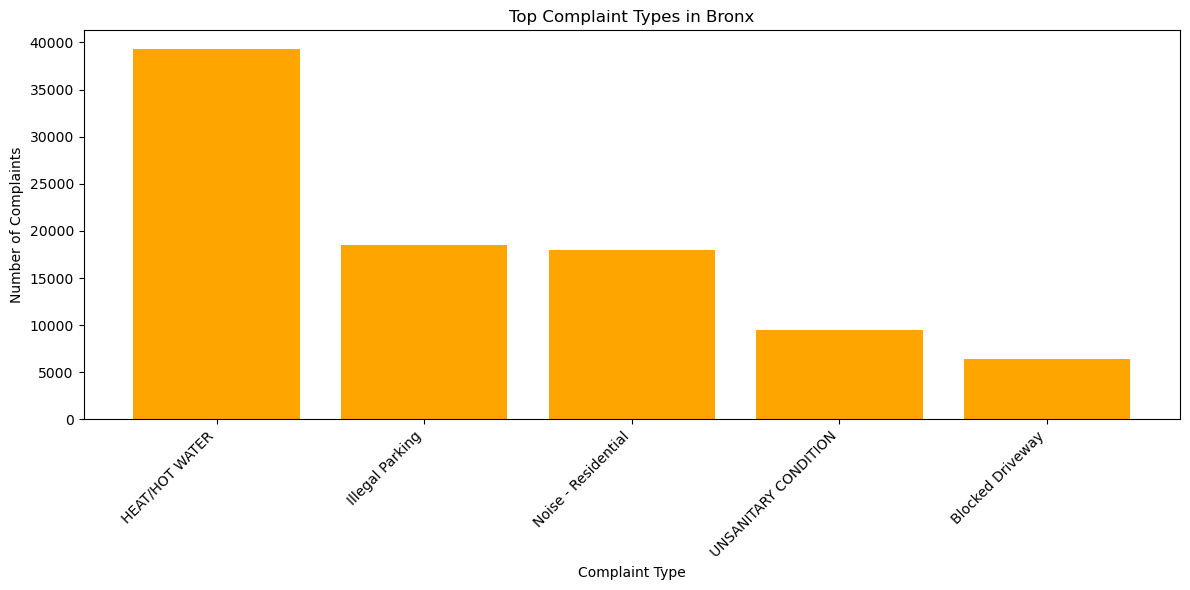

In [149]:
plt.figure(figsize=(12, 6))
plt.bar(bronx_complaints_sorted['complaint_type'][:5], bronx_complaints_sorted['count'][:5], color='orange')
plt.xlabel('Complaint Type')
plt.ylabel('Number of Complaints')
plt.title('Top Complaint Types in Bronx')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [147]:
staten_island_complaints = nyc311_service_line[nyc311_service_line['borough'] == 'STATEN ISLAND']
staten_island_complaints_counts = staten_island_complaints.groupby('complaint_type').size()
staten_island_complaints_df = staten_island_complaints_counts.reset_index(name='count')
staten_island_complaints_sorted = staten_island_complaints_df.sort_values(by='count', ascending=False)
staten_island_complaints_sorted.head()

,complaint_type,count
63,Illegal Parking,3580
116,Street Condition,2466
86,Noise - Residential,1524
2,Abandoned Vehicle,1142
52,HEAT/HOT WATER,1135


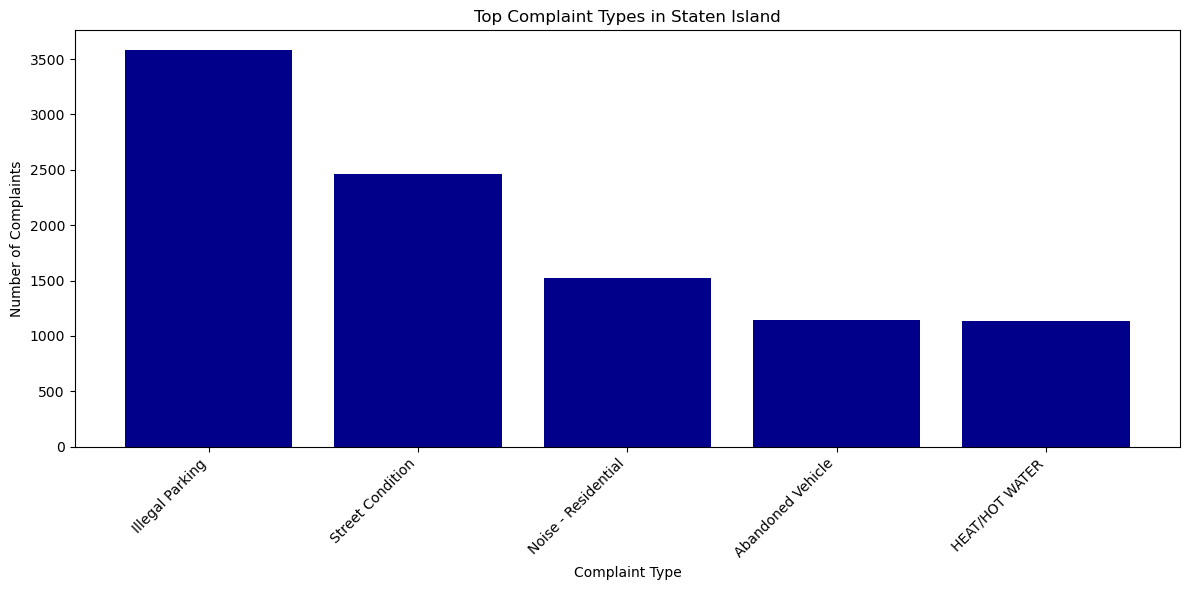

In [152]:
plt.figure(figsize=(12, 6))
plt.bar(staten_island_complaints_sorted['complaint_type'][:5], staten_island_complaints_sorted['count'][:5], color='darkblue')
plt.xlabel('Complaint Type')
plt.ylabel('Number of Complaints')
plt.title('Top Complaint Types in Staten Island')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [121]:
complaints_count = complaints_per_borough.groupby(['borough', 'complaint_type']).size().reset_index(name='count')
highest_complaint_idx = complaints_count.groupby('borough')['count'].idxmax()
highest_complaints_per_borough = complaints_count.loc[highest_complaint_idx]
highest_complaints_per_borough

,borough,complaint_type,count
61,BRONX,HEAT/HOT WATER,39312
231,BROOKLYN,Illegal Parking,47599
382,MANHATTAN,HEAT/HOT WATER,23341
555,QUEENS,Illegal Parking,36358
703,STATEN ISLAND,Illegal Parking,3580
787,Unspecified,Ferry Inquiry,75


In [122]:
complaints_count = complaints_per_borough.groupby(['borough', 'complaint_type']).size().reset_index(name='count')
lowest_complaint_idx = complaints_count.groupby('borough')['count'].idxmin()
lowest_complaints_per_borough = complaints_count.loc[lowest_complaint_idx]
lowest_complaints_per_borough

,borough,complaint_type,count
6,BRONX,Animal Facility - No Permit,1
163,BROOKLYN,Animal Facility - No Permit,1
336,MANHATTAN,Building Condition,1
501,QUEENS,Building Marshals office,1
654,STATEN ISLAND,Borough Office,1
780,Unspecified,Bike Rack Condition,1
